#CEIA - IIA - TP3: Detector de SPAM (20Co2025)

## Grupo 1 - 
### Miembros:
- Martín Brocca <martinbrocca@gmail.com>
- Emiliano Iparraguirre <emiliano.iparraguirre22@gmail.com>
- Natalia Espector <nataliaespector@gmail.com>
- Agustín Lopez Fredes <agustin.lopezfredes@gmail.com>
- Fernando Martinez <fgmartinez1989@gmail.com>

### Tareas y preguntas a resolver:

1. ¿Cuáles son las 10 palabras más encontradas en correos con SPAM y en correos No SPAM? ¿Hay palabras en común? ¿Algunas llaman la atención?
2. Separe el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba (70% y 30% respectivamente).
3. Utilizando un clasificador de Bayes ingenuo, entrene con el conjunto de entrenamiento.
4. Utilizando un clasificador de Regresión Logística, entrene con el conjunto de entrenamiento (en este caso, normalice los datos).
5. Calcule la matriz de confusión del conjunto de evaluación para ambos modelos. ¿Qué tipo de error comete más cada modelo? ¿Cuál de los dos tipos de error crees que es más importante para este problema?
6. Calcule la precisión y la recuperación de ambos modelos. Para cada métrica, ¿cuál es el mejor modelo? ¿Cómo se relacionan estas métricas con los tipos de errores analizados en el punto anterior? Expanda su respuesta.
7. Obtenga la curva ROC y el AUC (Área Bajo la Curva ROC) de ambos modelos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Scikit-learn nos ofrece una variedad ampliada de modelos Naive Bayes, para este problema usamos MultinomialNB que es pensado para este tipo de problemas
from sklearn.naive_bayes import MultinomialNB   

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# carga del csv en un dataframe de Pandas
dataset = pd.read_csv("./aux_data/spambase.csv") 
dataset.head(10)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,spam
0,0,640,640,0,320,0,0,0,0,0,...,0,0,0,0,0,0,778,0,0,1
1,210,280,500,0,140,280,210,70,0,940,...,0,0,0,0,132,0,372,180,48,1
2,60,0,710,0,1230,190,190,120,640,250,...,60,0,0,10,143,0,276,184,10,1
3,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,137,0,137,0,0,1
4,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,135,0,135,0,0,1
5,0,0,0,0,1850,0,0,1850,0,0,...,0,0,0,0,223,0,0,0,0,1
6,0,0,0,0,1920,0,0,0,0,640,...,0,0,0,0,54,0,164,54,0,1
7,0,0,0,0,1880,0,0,1880,0,0,...,0,0,0,0,206,0,0,0,0,1
8,150,0,460,0,610,0,300,0,920,760,...,0,0,0,0,271,0,181,203,22,1
9,60,120,770,0,190,320,380,0,60,0,...,0,0,0,40,30,0,244,81,0,1


In [8]:
dataset.shape

(4601, 55)

In [4]:
# agrupamos 
column_sum = dataset.groupby(by="spam", as_index=False).sum()
column_sum

,spam,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#
0,0,204860,681569,559220,2470,504739,124190,26160,107100,106080,...,1159138,800669,22840,142820,140182,442116,63242,306634,32475,60536
1,1,276190,298510,732080,298550,931799,317050,499309,377360,308320,...,226790,26700,2210,3810,37299,197563,14864,931352,316328,143003


1. ¿Cuáles son las 10 palabras más encontradas en correos con SPAM y en correos No SPAM? ¿Hay palabras en común? ¿Algunas llaman la atención?

In [6]:
#pivoteamos con melt para ordenar las palabras de mayor a menor:
total_words = column_sum.melt()
total_words

,variable,value
0,spam,0
1,spam,1
2,word_freq_make,204860
3,word_freq_make,276190
4,word_freq_address,681569
...,...,...
105,char_freq_!,931352
106,char_freq_$,32475
107,char_freq_$,316328
108,char_freq_#,60536


In [12]:
# Step 1: Identificar las columnas de palabras, sacando los caracteres,
word_columns = [col for col in column_sum.columns if col.startswith('word_freq_')]

# Step 2: Usar Melt para transponer la tabla
melted = pd.melt(
    column_sum,
    id_vars=['spam'],  # mantenemos la columna de  'spam'
    value_vars=word_columns,  # solo usamos las columnas de palabras
    var_name='word',  
    value_name='frequency'  # frecuencia de las palabras
)

# Step 3: sacamos "word_freq para mejorar la lectura
melted['word'] = melted['word'].str.replace('word_freq_', '')

# Step 4: encontramos el top 10 de palabras usadas.
# agrupamos por spam, ordenamos por frecuencia
top_words = melted.groupby('spam').apply(
    lambda x: x[['word', 'frequency']].sort_values(by='frequency', ascending=False).head(10),
    include_groups=False  
).reset_index()

# Step 5: mostrar resultados
non_spam_top = top_words[top_words['spam'] == 0][['word', 'frequency']]
spam_top = top_words[top_words['spam'] == 1][['word', 'frequency']]

print("Top 10 de palabras en correos no SPAM (spam=0):")
print(non_spam_top.reset_index(drop=True))
print("\nTop 10 de palabras en correos Spam (spam=1):")
print(spam_top.reset_index(drop=True))

Top 10 de palabras en correos no SPAM (spam=0):
      word  frequency
0      you    3541702
1   george    3527559
2       hp    2496576
3     will    1495268
4     your    1223098
5      hpl    1204398
6       re    1159138
7      edu     800669
8  address     681569
9  meeting     604460

Top 10 de palabras en correos Spam (spam=1):
       word  frequency
0       you    4105599
1      your    2502597
2      will     997100
3      free     939790
4       our     931799
5       all     732080
6      mail     635470
7     email     578759
8  business     521250
9    remove     499309


 
 La tabla a continuación muestra las 10 palabras mas comunes para correos SPAM y no SPAM
 Top 10 de palabras en correos no SPAM (spam=0):
 
  | Rank | Non-Spam Word | Non-Spam Frequency | Spam Word | Spam Frequency |
  |------|-----------|----------------|----------------|---------------------|
  | 1    | **you**       | 3,541,702      | **you**            | 4,105,599           |
  | 2    | george    | 3,527,559      | **your**           | 2,502,597           |
  | 3    | hp        | 2,496,576      | **will**           |   997,100           |
  | 4    | **will**      | 1,495,268      | free           |   939,790           |
  | 5    | **your**      | 1,223,098      | our            |   931,799           |
  | 6    | hpl       | 1,204,398      | all            |   732,080           |
  | 7    | re        | 1,159,138      | mail           |   635,470           |
  | 8    | edu       |   800,669      | email          |   578,759           |
  | 9    | address   |   681,569      | business       |   521,250           |
  | 10   | meeting   |   604,460      | remove         |   499,309           |

  Se observa que la palabra $you$ es la primera en las dos categorías y que $your$ y $will$ estan presentes en ambos lados de la tabla. 
  Es notable que en los correos de tipo SPAM, la frecuencia de la palabra $free$, como la del sigo de exclamación $!$ , $money$ se tienen una frecuencia mucho mayor que en correos no-SPAM

2. Separe el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba (70% y 30% respectivamente).

In [15]:
# Obtenemos los atributos y target
#X = (dataset.drop(columns="spam") * 100).astype(int)  # Esto es lo que puso el profesor, pero no creo qeu este bien porque el dataset no esta normalizado en % sino en grandes numeros.mr
X = dataset.drop(columns="spam")
y = dataset["spam"]

In [44]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state=42)

3. Utilizando un clasificador de Bayes ingenuo, entrene con el conjunto de entrenamiento. (escalado)

In [45]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline



In [46]:
pipeline_bayes_scaled = Pipeline(steps=[
    ('scaler', MinMaxScaler()),       # Escalado
    ('classifier', MultinomialNB())   # Modelo de Bayes Naive
])
pipeline_bayes_scaled

Pipeline(steps=[('scaler', MinMaxScaler()), ('classifier', MultinomialNB())])

In [52]:
pipeline_bayes_scaled.fit(X_train, y_train,)
print("Naive Bayes pipeline trained successfully.")
print("Número de muestras en el conjunto de entrenamiento:", len(X_train))
# print("Características utilizadas:", X.columns)
pipeline_bayes_scaled

Naive Bayes pipeline trained successfully.
Número de muestras en el conjunto de entrenamiento: 3220


Pipeline(steps=[('scaler', MinMaxScaler()), ('classifier', MultinomialNB())])

## Aca lo hago sin escalar, porque me llamo la atencion que pide escalar en el punto 4

In [53]:
pipeline_bayes_not_scaled = Pipeline(steps=[
    ('classifier', MultinomialNB())   # Modelo de Bayes Naive
])
pipeline_bayes_not_scaled

Pipeline(steps=[('classifier', MultinomialNB())])

In [54]:
pipeline_bayes_not_scaled.fit(X_train, y_train,)
print("Naive Bayes pipeline trained successfully.")
print("Número de muestras en el conjunto de entrenamiento:", len(X_train))
# print("Características utilizadas:", X.columns)
pipeline_bayes_not_scaled

Naive Bayes pipeline trained successfully.
Número de muestras en el conjunto de entrenamiento: 3220


Pipeline(steps=[('classifier', MultinomialNB())])

## aca no me gustaba como quedaban las columnas identificadas y lo limpie un poco, sacar si no les parece

In [55]:
#que pasa si filtro mas columnas:
# Seleccionar columnas relevantes (excluimos métricas de mayúsculas)
feature_columns = [col for col in dataset.columns if col.startswith('word_freq_') or col.startswith('char_freq_')]
X_filt = dataset[feature_columns]
y_filt = dataset["spam"]
# Paso 2: Dividir en conjunto de entrenamiento y prueba
X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
pipeline_bayes_scaled.fit(X_train_filt, y_train_filt,)
print("Modelo Naive Bayes entrenado con éxito.")
print("Número de muestras en el conjunto de entrenamiento:", len(X_train))
print("Características utilizadas:", feature_columns)
pipeline_bayes_scaled

Naive Bayes pipeline trained successfully.
Número de muestras en el conjunto de entrenamiento: 3220
Características utilizadas: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_t

Pipeline(steps=[('scaler', MinMaxScaler()), ('classifier', MultinomialNB())])

4. Utilizando un clasificador de Regresión Logística, entrene con el conjunto de entrenamiento (en este caso, normalice los datos).

In [59]:
pipeline_logistic_reg = Pipeline(steps=[
    ('scaler', StandardScaler()),       # Escalado
    ('classifier', LogisticRegression())   # Modelo de regresion logistica
])
pipeline_logistic_reg

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression())])

In [60]:
pipeline_logistic_reg.fit(X_train, y_train,)
print("Modelo de Logistic Regression entrenado con éxito.")
print("Número de muestras en el conjunto de entrenamiento:", len(X_train))
# print("Características utilizadas:", X.columns)
pipeline_logistic_reg

Modelo de Logistic Regression entrenado con éxito.
Número de muestras en el conjunto de entrenamiento: 3220


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression())])

5. Calcule la matriz de confusión del conjunto de evaluación para ambos modelos. ¿Qué tipo de error comete más cada modelo? ¿Cuál de los dos tipos de error crees que es más importante para este problema?


In [61]:
y_pred_nb = pipeline_bayes_scaled.predict(X_test)
cm_nb = confusion_matrix(y_test, y_pred_nb)
print("Matriz de confusión del modelo Naive de Bayes:")
print(cm_nb)

Matriz de confusión del modelo Naive de Bayes:
[[780  24]
 [137 440]]


In [62]:
y_pred_lr = pipeline_logistic_reg.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("\nLogistic Regression Confusion Matrix:")
print(cm_lr)


Logistic Regression Confusion Matrix:
[[771  33]
 [ 75 502]]


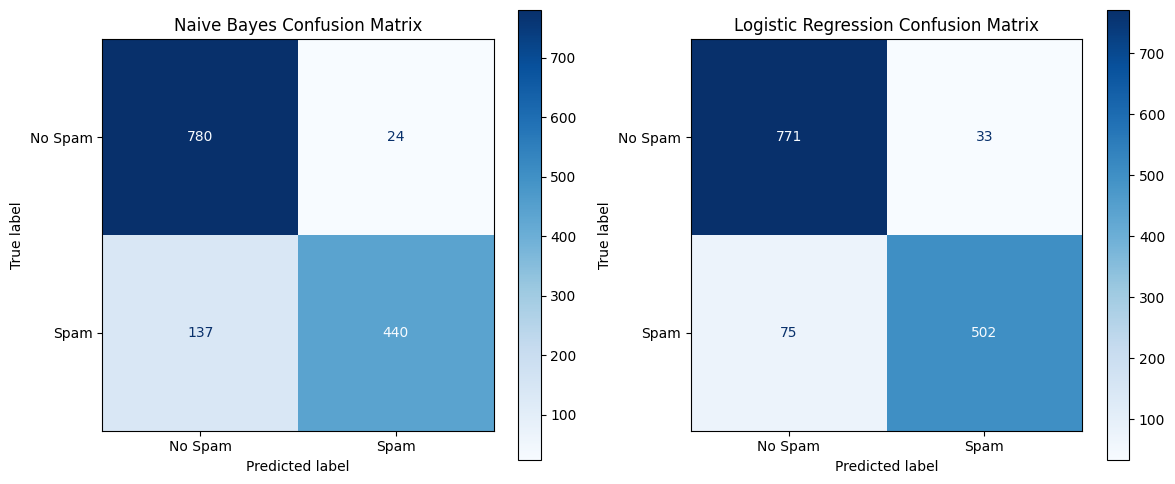

In [63]:
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=["No Spam", "Spam"])
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["No Spam", "Spam"])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
disp_nb.plot(ax=plt.gca(), cmap='Blues')
plt.title("Naive Bayes Confusion Matrix")

plt.subplot(1, 2, 2)
disp_lr.plot(ax=plt.gca(), cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.tight_layout()
plt.show()

**Análisis**:
 - El modelo Naive Bayes comete más falsos negativos (137), es decir, clasifica muchos correos SPAM como no-SPAM.
 - En cambio, Regresión Logística tiene menos falsos negativos (75), aunque un poco más de falsos positivos (33 vs 24).
**Importancia de este tipo de error**:
 - El problema de clasificación de correos de tipo SPAM tiene diferentes puntos de vista que pueden determinar que algoritmo es el mejor:
     - En ambientes coorporativos, en donde la seguridad es la prioridad en la clasificación por sobre la conveniencia del usuario, los falsos negativos presentan un mayor costo al permitir que correo no deseado llegue a la bandeja de entrada. Esto incrementa el riesgo y peligro para toda la compañia. En este caso, el modelo de Regresión Logística resulta más adecuado.
     - En ambientes de usuarios finales, en donde el riesgo es solo para el individuo, los falsos positivos, es decir correo legítimo identificado como SPAM, es menos deseable. En este caso Naive Bayes es preferible. 

6. Calcule la precisión y la recuperación de ambos modelos. Para cada métrica, ¿cuál es el mejor modelo? ¿Cómo se relacionan estas métricas con los tipos de errores analizados en el punto anterior? Expanda su respuesta.


## Metrics

- **Precision**: Proporción de emails predichos como spam que verdaderamente eran Spam.
  Precision = TP / (TP + FP)
  Una precisión alta significa una menor cantidad de falso positivos (menos emails legítimos marcados como spam).

- **Recall**: Proporción de spam emails correctamente identificados. 
  Recall = TP / (TP + FN)
  Un alto recall significa una menor cantidad de falsos negativos (menos spam emails no identificados).

In [64]:
# --- Calculate Precision and Recall ---
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)

In [65]:
# --- Print Results ---
print("Naive Bayes:")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")

print("\nLogistic Regression:")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")

Naive Bayes:
Precision: 0.9483
Recall: 0.7626

Logistic Regression:
Precision: 0.9383
Recall: 0.8700


Precisión (Precision) mide cuántos de los correos marcados como SPAM realmente lo eran. Es sensible a falsos positivos.

Recuperación (Recall) mide cuántos de los correos SPAM fueron detectados correctamente. Es sensible a falsos negativos.

Estimación cualitativa:

|Métrica	| Naive Bayes	| Regresión Logística| 
|-----------|---------------|--------------------|
|Precisión	|Alta (pocos falsos positivos)|	Levemente menor|
|Recall	|Más baja (muchos falsos negativos) |	Mejor|

En conclusión: 

Naive Bayes tiene mejor precisión.

Regresión Logística tiene mejor recall, lo cual es más valioso en este contexto.

7. Obtenga la curva ROC y el AUC (Área Bajo la Curva ROC) de ambos modelos.

In [72]:
from sklearn.metrics import roc_curve, roc_auc_score

# --- Computar ROC y AUC ---
# Naive Bayes: Get probability scores
y_prob_nb = pipeline_bayes_scaled.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
auc_nb = roc_auc_score(y_test, y_prob_nb)

# Logistic Regression: Get probability scores
y_prob_lr = pipeline_logistic_reg.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)


Naive Bayes AUC: 0.959
Logistic Regression AUC: 0.973


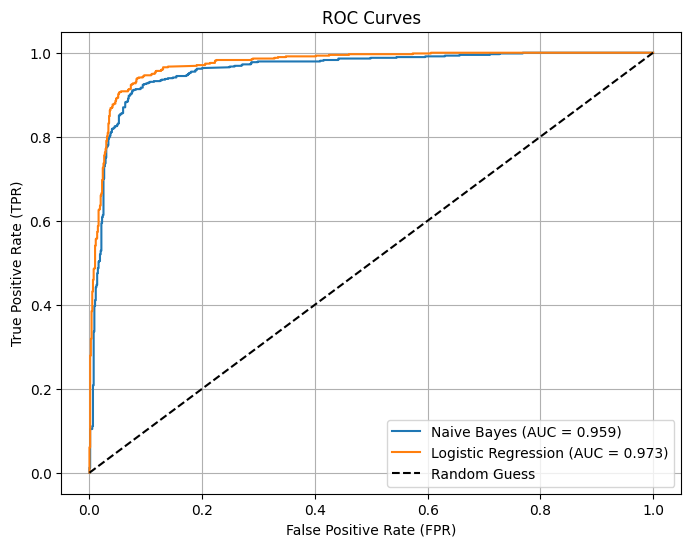

In [74]:

# --- Print AUC ---
print(f"Naive Bayes AUC: {auc_nb:.3f}")
print(f"Logistic Regression AUC: {auc_lr:.3f}")

# --- Plot ROC Curves ---
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.3f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

Conclusiones generales del trabajo:


1. Ambos modelos son válidos para el problema de clasificación de SPAM, pero muestran distintos comportamientos frente a los errores.

2. En ambientes coorporativos y de alta seguridad, la Regresión Logística resulta más conveniente por su menor tasa de falsos negativos, aunque a costa de algunos falsos positivos adicionales. Para entornos de usuarios finales, Naive Bayes es preferible.

3. El análisis de métricas complementarias como precisión, recall, y AUC permite una evaluación más completa que simplemente observar la exactitud.

4. La importancia del preprocesamiento (como la normalización para Regresión Logística) fue clave para mejorar los resultados.

5. Se evidenció que ningún modelo es perfecto, pero según el problema de negocio, minimizar falsos negativos es crítico, lo cual guía la elección del modelo.
